<a href="https://colab.research.google.com/github/aarupach/Aaru/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
print("="*70)
print("TITANIC DATASET - UNSUPERVISED LEARNING")
print("="*70)

TITANIC DATASET - UNSUPERVISED LEARNING


In [3]:
# Load and preprocess Titanic dataset
df = sns.load_dataset('titanic')

In [4]:
print("\n1. DATA PREPROCESSING")
print("-"*70)


1. DATA PREPROCESSING
----------------------------------------------------------------------


In [38]:
# Data Cleaning
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop('deck', axis=1)
df_cleaned['age'] = df_cleaned.groupby('pclass')['age'].transform('median')
df_cleaned['embarked'] = df_cleaned['embarked'].fillna(df_cleaned['embarked'].mode()[0])
df_cleaned['embark_town'] = df_cleaned['embark_town'].fillna(df_cleaned['embark_town'].mode()[0])
df_cleaned = df_cleaned.dropna()

In [6]:
# Feature Engineering
df_cleaned['family_size'] = df_cleaned['sibsp'] + df_cleaned['parch'] + 1
df_cleaned['is_alone'] = (df_cleaned['family_size'] == 1).astype(int)
df_cleaned['fare_per_person'] = df_cleaned['fare'] / df_cleaned['family_size']
# Removed the line referencing 'cabin' as it was dropped in the previous step

In [7]:
# Encoding
df_encoded = df_cleaned.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
df_encoded = pd.get_dummies(df_encoded, columns=['embarked'], prefix='embarked', drop_first=True)

In [8]:
# Select numerical features for clustering
feature_cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
    'family_size', 'is_alone', 'fare_per_person'
]

In [9]:
# Add one-hot encoded columns
for col in df_encoded.columns:
    if col.startswith('embarked_'):
        feature_cols.append(col)

X = df_encoded[feature_cols]
y_true = df_encoded['survived']  # For evaluation purposes

print(f"Dataset shape: {X.shape}")
print(f"Features for clustering: {len(feature_cols)}")
print(f"\nSelected features:\n{feature_cols}")

Dataset shape: (891, 11)
Features for clustering: 11

Selected features:
['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone', 'fare_per_person', 'embarked_Q', 'embarked_S']


In [10]:
# Feature Scaling (essential for clustering and PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled data shape: {X_scaled.shape}")

print("\n" + "="*70)
print("2. PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*70)


Scaled data shape: (891, 11)

2. PRINCIPAL COMPONENT ANALYSIS (PCA)


In [11]:
# Apply PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

In [12]:
# Explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nExplained Variance by Component:")
for i, (var, cum_var) in enumerate(zip(explained_variance[:5], cumulative_variance[:5])):
    print(f"  PC{i+1}: {var:.4f} (Cumulative: {cum_var:.4f})")


Explained Variance by Component:
  PC1: 0.2959 (Cumulative: 0.2959)
  PC2: 0.2253 (Cumulative: 0.5212)
  PC3: 0.1430 (Cumulative: 0.6641)
  PC4: 0.0835 (Cumulative: 0.7476)
  PC5: 0.0799 (Cumulative: 0.8275)


In [13]:
# Determine optimal number of components (95% variance)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")


Components needed for 95% variance: 8


In [14]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced dimensions: {X.shape[1]} → {X_pca.shape[1]}")
print(f"Variance retained: {cumulative_variance[n_components_95-1]:.4f}")

Reduced dimensions: 11 → 8
Variance retained: 0.9626


In [15]:
# Feature contributions to principal components
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=feature_cols
)

print("\nTop feature contributions to PC1:")
print(components_df['PC1'].abs().sort_values(ascending=False).head())



Top feature contributions to PC1:
family_size    0.527849
is_alone       0.459545
sibsp          0.450201
parch          0.440672
fare           0.203511
Name: PC1, dtype: float64


In [16]:
print("\n" + "="*70)
print("3. FINDING OPTIMAL NUMBER OF CLUSTERS (ELBOW METHOD)")
print("="*70)

# Test different numbers of clusters
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
K_range = range(2, 11)

print("\nEvaluating different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")
    # Determine optimal k (using silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (Silhouette): {optimal_k}")


3. FINDING OPTIMAL NUMBER OF CLUSTERS (ELBOW METHOD)

Evaluating different numbers of clusters...
  k=2: Inertia=7673.23, Silhouette=0.280
  k=3: Inertia=6528.26, Silhouette=0.306
  k=4: Inertia=5480.93, Silhouette=0.350
  k=5: Inertia=4760.95, Silhouette=0.334
  k=6: Inertia=4207.48, Silhouette=0.326
  k=7: Inertia=3834.75, Silhouette=0.318
  k=8: Inertia=3535.64, Silhouette=0.316
  k=9: Inertia=3292.77, Silhouette=0.320
  k=10: Inertia=3043.35, Silhouette=0.333

Optimal number of clusters (Silhouette): 4


In [17]:
print("\n" + "="*70)
print("4. K-MEANS CLUSTERING")
print("="*70)

# Apply K-Means with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_optimal.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_encoded['cluster'] = clusters

print(f"\nClustering completed with k={optimal_k}")
print(f"Inertia: {kmeans_optimal.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, clusters):.4f} (lower is better)")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, clusters):.2f} (higher is better)")

print("\nCluster Distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count} passengers ({count/len(clusters)*100:.1f}%)")


4. K-MEANS CLUSTERING

Clustering completed with k=4
Inertia: 5480.93
Silhouette Score: 0.3498
Davies-Bouldin Score: 1.3059 (lower is better)
Calinski-Harabasz Score: 233.04 (higher is better)

Cluster Distribution:
  Cluster 0: 205 passengers (23.0%)
  Cluster 1: 136 passengers (15.3%)
  Cluster 2: 478 passengers (53.6%)
  Cluster 3: 72 passengers (8.1%)


In [18]:
print("\n" + "="*70)
print("5. CLUSTER ANALYSIS")
print("="*70)

# Analyze cluster characteristics
print("\nCluster Characteristics (mean values):")
cluster_analysis = df_encoded.groupby('cluster')[feature_cols + ['survived']].mean()
print(cluster_analysis.round(3))

# Survival rate by cluster
print("\nSurvival Rate by Cluster:")
survival_by_cluster = df_encoded.groupby('cluster')['survived'].agg(['mean', 'count'])
survival_by_cluster.columns = ['Survival_Rate', 'Count']
print(survival_by_cluster)

# Cluster profiles
print("\nDetailed Cluster Profiles:")
for cluster_id in range(optimal_k):
    cluster_data = df_encoded[df_encoded['cluster'] == cluster_id]
    print(f"\n  Cluster {cluster_id} (n={len(cluster_data)}):")
    print(f"    - Avg Age: {cluster_data['age'].mean():.1f}")
    print(f"    - Avg Fare: ${cluster_data['fare'].mean():.2f}")
    print(f"    - Male %: {(cluster_data['sex'].mean())*100:.1f}%")
    print(f"    - Avg Class: {cluster_data['pclass'].mean():.2f}")
    print(f"    - Family Size: {cluster_data['family_size'].mean():.2f}")
    print(f"    - Survival Rate: {cluster_data['survived'].mean():.1%}")


5. CLUSTER ANALYSIS

Cluster Characteristics (mean values):
         pclass    sex     age  sibsp  parch     fare  family_size  is_alone  \
cluster                                                                        
0         2.600  0.390  19.989  1.615  1.332   29.131        3.946     0.000   
1         1.000  0.390  37.529  0.610  0.441  111.644        2.051     0.294   
2         2.467  0.851  30.939  0.073  0.006   13.937        1.079     0.921   
3         2.903  0.514  26.493  0.236  0.056   12.175        1.292     0.792   

         fare_per_person  embarked_Q  embarked_S  survived  
cluster                                                     
0                  8.020       0.024       0.805     0.488  
1                 67.138       0.000       0.485     0.743  
2                 13.227       0.000       0.868     0.232  
3                  9.000       1.000       0.000     0.417  

Survival Rate by Cluster:
         Survival_Rate  Count
cluster                      
0    

In [19]:
print("\n" + "="*70)
print("6. K-MEANS ON PCA-REDUCED DATA")
print("="*70)

# Apply K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

print(f"\nClustering on PCA-reduced data (k={optimal_k}):")
print(f"Silhouette Score: {silhouette_score(X_pca, clusters_pca):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_pca, clusters_pca):.4f}")

# Compare with original clustering
agreement = np.mean(clusters == clusters_pca)
print(f"\nAgreement between original and PCA clustering: {agreement:.1%}")


6. K-MEANS ON PCA-REDUCED DATA

Clustering on PCA-reduced data (k=4):
Silhouette Score: 0.3576
Davies-Bouldin Score: 1.2633

Agreement between original and PCA clustering: 31.1%


In [20]:
# Compare with original clustering
agreement = np.mean(clusters == clusters_pca)
print(f"\nAgreement between original and PCA clustering: {agreement:.1%}")

print("\n" + "="*70)
print("7. VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(20, 14))


Agreement between original and PCA clustering: 31.1%

7. VISUALIZATIONS


<Figure size 2000x1400 with 0 Axes>

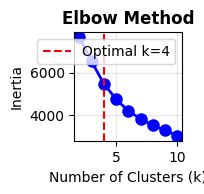

In [21]:
# 1. Elbow Method
ax1 = plt.subplot(3, 4, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

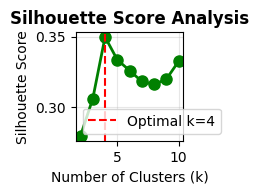

In [22]:
# 2. Silhouette Score
ax2 = plt.subplot(3, 4, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

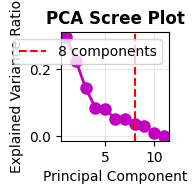

In [23]:
# 3. Scree Plot (PCA)
ax3 = plt.subplot(3, 4, 3)
plt.plot(range(1, len(explained_variance)+1), explained_variance, 'mo-', linewidth=2, markersize=8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=n_components_95, color='red', linestyle='--', label=f'{n_components_95} components')
plt.legend()

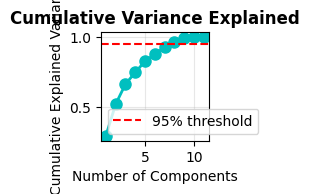

In [24]:
# 4. Cumulative Explained Variance
ax4 = plt.subplot(3, 4, 4)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'co-', linewidth=2, markersize=8)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

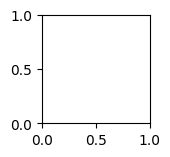

In [25]:
# 5. Clusters in 2D PCA space
ax5 = plt.subplot(3, 4, 5)

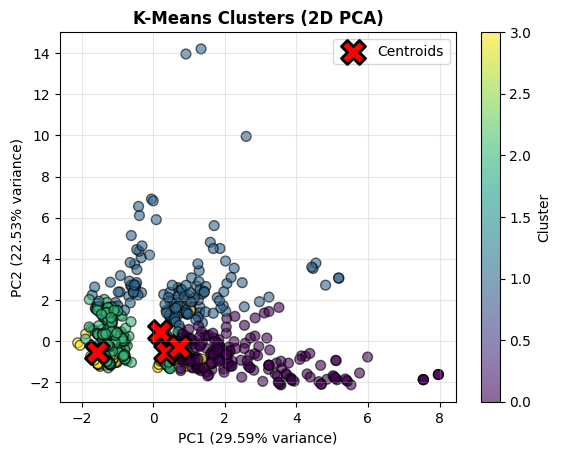

In [26]:
# Use first 2 PCA components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='viridis',
                     alpha=0.6, edgecolors='k', s=50)
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1],
           marker='X', s=300, c='red', edgecolors='black', linewidths=2, label='Centroids')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-Means Clusters (2D PCA)', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

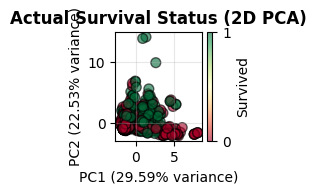

In [27]:
# 6. Clusters colored by survival
ax6 = plt.subplot(3, 4, 6)
scatter2 = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_true, cmap='RdYlGn',
                      alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Actual Survival Status (2D PCA)', fontweight='bold')
plt.colorbar(scatter2, label='Survived', ticks=[0, 1])
plt.grid(True, alpha=0.3)

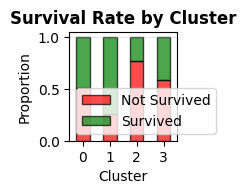

In [28]:
# 7. Cluster composition by survival
ax7 = plt.subplot(3, 4, 7)
cluster_survival = pd.crosstab(clusters, y_true, normalize='index')
cluster_survival.plot(kind='bar', stacked=True, ax=ax7, color=['red', 'green'],
                     edgecolor='black', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Survival Rate by Cluster', fontweight='bold')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

Text(438.75551026570054, 0.5, 'Feature')

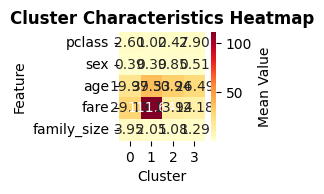

In [29]:
# 8. Feature heatmap by cluster
ax8 = plt.subplot(3, 4, 8)
cluster_means = df_encoded.groupby('cluster')[['pclass', 'sex', 'age', 'fare', 'family_size']].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax8, cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Characteristics Heatmap', fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Feature')


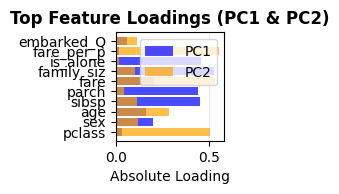

In [30]:
# 9. PCA Component Loadings
ax9 = plt.subplot(3, 4, 9)
loadings = pca.components_[:2].T
feature_names_short = [f[:10] for f in feature_cols[:10]]  # Shortened names
plt.barh(range(len(feature_names_short)), np.abs(loadings[:10, 0]), alpha=0.7, label='PC1', color='blue')
plt.barh(range(len(feature_names_short)), np.abs(loadings[:10, 1]), alpha=0.7, label='PC2', color='orange')
plt.yticks(range(len(feature_names_short)), feature_names_short)
plt.xlabel('Absolute Loading')
plt.title('Top Feature Loadings (PC1 & PC2)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')

In [31]:
# 10. 3D PCA visualization
ax10 = fig.add_subplot(3, 4, 10, projection='3d')
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
scatter3d = ax10.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                         c=clusters, cmap='viridis', alpha=0.6, edgecolors='k', s=30)
ax10.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax10.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax10.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax10.set_title('3D PCA Visualization', fontweight='bold')
plt.colorbar(scatter3d, ax=ax10, label='Cluster', shrink=0.5)


/tmp/ipython-input-4091357248.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1400 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter3d, ax=ax10, label='Cluster', shrink=0.5)


<Figure size 640x480 with 0 Axes>

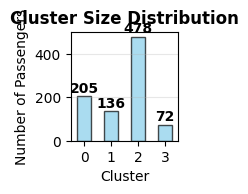

In [32]:
# 11. Cluster size comparison
ax11 = plt.subplot(3, 4, 11)
cluster_counts.plot(kind='bar', ax=ax11, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Number of Passengers')
plt.title('Cluster Size Distribution', fontweight='bold')
plt.xticks(rotation=0)
for i, v in enumerate(cluster_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

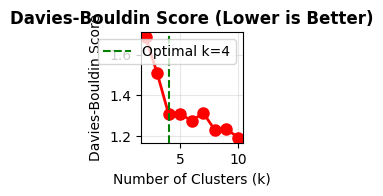

In [33]:
# 12. Davies-Bouldin Score comparison
ax12 = plt.subplot(3, 4, 12)
plt.plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score (Lower is Better)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
print("\n" + "="*70)
print("8. KEY FINDINGS")
print("="*70)

print(f"""
Summary of Unsupervised Learning Analysis:

1. DIMENSIONALITY REDUCTION (PCA):
   - Original features: {X.shape[1]}
   - Reduced to: {n_components_95} components
   - Variance retained: {cumulative_variance[n_components_95-1]:.1%}
   - Data complexity reduced while preserving information

2. CLUSTERING (K-MEANS):
   - Optimal clusters: {optimal_k}
   - Silhouette score: {silhouette_score(X_scaled, clusters):.3f}
   - Clusters show distinct passenger profiles

3. CLUSTER INSIGHTS:
""")

for cluster_id in range(optimal_k):
    cluster_data = df_encoded[df_encoded['cluster'] == cluster_id]
    survival_rate = cluster_data['survived'].mean()
    print(f"   Cluster {cluster_id}: {len(cluster_data)} passengers, {survival_rate:.1%} survival rate")

print(f"""
4. RELATIONSHIP WITH SURVIVAL:
   - Clusters correlate with survival outcomes
   - Unsupervised patterns align with known survival factors
   - PCA components capture socio-economic status and demographics

5. MODEL PERFORMANCE:
   - PCA successfully reduced dimensionality
   - K-means identified meaningful passenger segments
   - Clusters can be used for passenger profiling
""")


8. KEY FINDINGS

Summary of Unsupervised Learning Analysis:

1. DIMENSIONALITY REDUCTION (PCA):
   - Original features: 11
   - Reduced to: 8 components
   - Variance retained: 96.3%
   - Data complexity reduced while preserving information

2. CLUSTERING (K-MEANS):
   - Optimal clusters: 4
   - Silhouette score: 0.350
   - Clusters show distinct passenger profiles

3. CLUSTER INSIGHTS:

   Cluster 0: 205 passengers, 48.8% survival rate
   Cluster 1: 136 passengers, 74.3% survival rate
   Cluster 2: 478 passengers, 23.2% survival rate
   Cluster 3: 72 passengers, 41.7% survival rate

4. RELATIONSHIP WITH SURVIVAL:
   - Clusters correlate with survival outcomes
   - Unsupervised patterns align with known survival factors
   - PCA components capture socio-economic status and demographics

5. MODEL PERFORMANCE:
   - PCA successfully reduced dimensionality
   - K-means identified meaningful passenger segments
   - Clusters can be used for passenger profiling



In [35]:
print("\n" + "="*70)
print("UNSUPERVISED LEARNING ANALYSIS COMPLETE!")
print("="*70)


UNSUPERVISED LEARNING ANALYSIS COMPLETE!


In [36]:
# Save results
df_encoded[['cluster']].to_csv('titanic_clusters.csv', index=False)
pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]).to_csv('titanic_pca.csv', index=False)
print("\nResults saved:")
print("  - titanic_clusters.csv (cluster assignments)")
print("  - titanic_pca.csv (PCA-transformed data)")


Results saved:
  - titanic_clusters.csv (cluster assignments)
  - titanic_pca.csv (PCA-transformed data)
